In [ ]:
# download the dataset
!wget -O shakespeare.txt https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/shakespeare.txt
!wget -O spenser.txt https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/spenser.txt
!wget -O Syllable_dictionary.txt https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/Syllable_dictionary.txt

--2023-03-12 01:40:42--  https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/shakespeare.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98029 (96K) [text/plain]
Saving to: ‘shakespeare.txt’

shakespeare.txt     100%[===================>]  95.73K  --.-KB/s    in 0.01s   

2023-03-12 01:40:42 (6.56 MB/s) - ‘shakespeare.txt’ saved [98029/98029]

--2023-03-12 01:40:42--  https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/spenser.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting re

In [ ]:
# download our hw6_shet
!wget -O hw6_code_that_we_use.py https://raw.githubusercontent.com/randomlylelo/shakespearebot_5000/main/hw6_code_that_we_use.py

--2023-03-12 01:40:46--  https://raw.githubusercontent.com/randomlylelo/shakespearebot_5000/main/hw6_code_that_we_use.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22335 (22K) [text/plain]
Saving to: ‘hw6_code_that_we_use.py’

hw6_code_that_we_us 100%[===================>]  21.81K  --.-KB/s    in 0.002s  

2023-03-12 01:40:46 (13.2 MB/s) - ‘hw6_code_that_we_use.py’ saved [22335/22335]



In [ ]:
from nltk.corpus import cmudict
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import urllib
from tqdm import tqdm

In [ ]:
####################
# WORDCLOUD FUNCTIONS
####################

def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud

def states_to_wordclouds(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds

In [ ]:
####################
# HMM FUNCTIONS
####################

def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []
        
        for word in line:
            word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1
            
            # Add the encoded word.
            obs_elem.append(obs_map[word])
        
        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def sample_sentence(hmm, obs_map, n_words=100, seed=None):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission, states = hmm.generate_emission(n_words, seed=seed)
    sentence = [obs_map_r[i] for i in emission]

    return ' '.join(sentence).capitalize() + '...'


####################
# HMM VISUALIZATION FUNCTIONS
####################

def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()


####################
# HMM ANIMATION FUNCTIONS
####################

def animate_emission(hmm, obs_map, M=8, height=12, width=12, delay=1, seed=None):
    # Parameters.
    lim = 1200
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 580
    y_offset = 520
    R = 420
    r = 100
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06
    
    # Initialize.
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = states_to_wordclouds(hmm, obs_map, max_words=20, show=False)

    # Initialize plot.    
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid('off')
    plt.axis('off')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(wordcloud.to_array(), extent=(x - r, x + r, y - r, y + r), aspect='auto', zorder=-1)

    # Initialize text.
    text = ax.text(text_x_offset, lim - text_y_offset, '', fontsize=24)
        
    # Make the arrows.
    zorder_mult = n_states ** 2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)
            
            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(x_i + (r/d + arrow_p1) * dx + arrow_p2 * dy,
                                 y_i + (r/d + arrow_p1) * dy + arrow_p2 * dx,
                                 (1 - 2 * r/d - arrow_p3) * dx,
                                 (1 - 2 * r/d - arrow_p3) * dy,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))
            else:
                arrow = ax.arrow(x_i, y_i, 0, 0,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))

            row.append(arrow)
        arrows.append(row)

    emission, states = hmm.generate_emission(M, seed=seed)

    def animate(i):
        if i >= delay:
            i -= delay

            if i == 0:
                arrows[states[0]][states[0]].set_color('red')
            elif i == 1:
                arrows[states[0]][states[0]].set_color((1 - hmm.A[states[0]][states[0]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')
            else:
                arrows[states[i - 2]][states[i - 1]].set_color((1 - hmm.A[states[i - 2]][states[i - 1]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')

            # Set text.
            text.set_text(' '.join([obs_map_r[e] for e in emission][:i+1]).capitalize())

            return arrows + [text]

    # Animate!
    print('\nAnimating...')
    anim = FuncAnimation(fig, animate, frames=M+delay, interval=1000)

    return anim


In [ ]:
from hw6_code_that_we_use import parse_observations, unsupervised_HMM, sample_sentence

In [ ]:
import nltk
nltk.download('cmudict')

# constants
SYLLABLE_DICTIONARY_PATH = 'Syllable_dictionary.txt'
SHAKESPEARE_DATA = 'shakespeare.txt'

syllable_dict = {}
with open(SYLLABLE_DICTIONARY_PATH, 'r') as f:
    for line in f:
        line = line.strip()

        if line:
            sentence = line.split(' ')
            word = sentence[0]
            syllable_dict[word] = sentence[1:]
            
def has_digit(string):
    return any(char.isdigit() for char in string)


def remove_punctuation(string):
    return re.sub(r'[^\w\s]', '', string)

with open(SHAKESPEARE_DATA, 'r') as f:
    all_data = f.readlines()
    all_lines = list(filter(lambda line: not has_digit(line), all_data))

    def clean_line(line):
        words = line.split(' ')

        words_no_punc = []

        for word in words:
            # Remove punctuation
            words_no_punc.append(remove_punctuation(word).strip())

        return words_no_punc

    X = list(map(clean_line, all_lines))

    X, X_map = parse_observations(X)

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


In [ ]:
num_hidden_states = 10
# more iters take a while
N_iters = 10
HMM = unsupervised_HMM(X, num_hidden_states, N_iters, seed=None)

100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


# Sonnet Generation

In [ ]:
rhyme_groups = {}

def convert(lst):
    return ([i for i in lst.split()])

def sentenceSyllable(sent): #for haikus only
    sentence = convert(sent)
    syllables = 0
    for word in sentence:
        word = remove_punctuation(word)
        if(word != ' '):  
            if (word.lower() in syllable_dict) == False:
                return 1000 #auto reject
            
            count = syllable_dict[word.lower()][0]
            
            
            if 'E' in count:
                count = int(count[1:])
            else:
                count = int(count)
        else:
            count = 0
        
            
        syllables += count
    
    return syllables

In [ ]:
for _ in tqdm(range(1000)):
    line = sample_sentence(HMM, X_map, n_words=random.randint(1, 10))
    while sentenceSyllable(line) != 10:
        line = sample_sentence(HMM, X_map, n_words=random.randint(1, 10))
    word_list = line.split(" ")
    last_word = word_list[len(word_list) - 1]
    if (len(last_word) < 2):
        continue

    last_2_letters = last_word[len(last_word)-2:]
    if last_2_letters not in rhyme_groups:
        rhyme_groups[last_2_letters] = []
    rhyme_groups[last_2_letters].append(line)  # getting the last 2 letters and using it as a dictionary key

print(rhyme_groups)



#%%
# get rhyming to work
to_print = []
last_word_set = set()

for key in rhyme_groups:
    lst = rhyme_groups[key]
    if len(lst) > 2:
        counter = 0
        # deal with the case where there is no two
        to_add_to_print = []
        for sentence in lst:
            last_word = sentence.split()[-1]
            if last_word not in last_word_set:
                counter += 1
                to_add_to_print.append(sentence)
                last_word_set.add(last_word)

            if counter == 2:
                for str in to_add_to_print:
                    to_print.append(str)
                break

    if len(to_print) == 14:
        break

print(to_print[0]) # a
print(to_print[2]) # b
print(to_print[1]) # a
print(to_print[3]) # b
print()

print(to_print[4]) # c
print(to_print[6]) # d
print(to_print[5]) # c
print(to_print[7]) # d
print()

print(to_print[8]) # e
print(to_print[10]) # f
print(to_print[9]) # e
print(to_print[11]) # f
print()

print(to_print[12]) # g
print(to_print[13]) # g

100%|██████████| 1000/1000 [00:45<00:00, 22.03it/s]

{'er': ['Wound such thee were he watch face plea as her', 'Therefore spring jade dressing give mine for longer', 'Hand halt shall bail every ladies of her', 'Every raven when world was like linger', 'Show know heaven lords no but a things and power', 'Sin that constant from with rise are anger', 'Once see wound flowers tombed sleep cloak her their cover', 'Eyes every thy sits disdains  tripping her', 'Or were forget deep canst verse love after', 'Much birth his glory it forfeit my tender', 'Come wealth by as things soul looks profane other', 'So ere  a may a alone  whence ever', 'Swerving have for upon can not greater the lover', 'Thy and it their ages ill the the never', 'The thy care wrack reasons of loves me power', 'And worth saucy wilt and hours cannot her', ' eyes a once triumph taken to it riper', 'Directly day me more seem thy oft flower', 'This strife heaven thy dost now stirred but i fever', 'Me is make my cunning gay and the mother'], 'is': ['That doth acknowledge thou fair 

# Haiku Generation

In [ ]:
def ShakespeareHaiku():
    #print("Running: 0%", end='\r')
    haiku = []
    five = True
    while five:
        test = sample_sentence(HMM, X_map, n_words=random.randint(1, 5))
        if sentenceSyllable(test) == 5:
            five = False
            haiku.append(test)
    #print("Running: 33%", end='\r')
    
    seven = True
    while seven:
        test = sample_sentence(HMM, X_map, n_words=random.randint(1, 7))
        if sentenceSyllable(test) == 7:
            seven = False
            haiku.append(test)            
    #print("Running: 67%", end='\r')
    
    five = True
    while five:
        test = sample_sentence(HMM, X_map, n_words=random.randint(1, 5))
        if sentenceSyllable(test) == 5:
            five = False
            haiku.append(test+".")
    #print("Done                    ", end='\r')
    #print()
    #print()
    
    for i in range(3):
        print(haiku[i])

    print()
    
    return haiku

In [ ]:
ShakespeareHaiku()

Being and him from from
My thy all i assailed when
Break so enclose those.



['Being and him from from',
 'My thy all i assailed when',
 'Break so enclose those.']

# Visualization

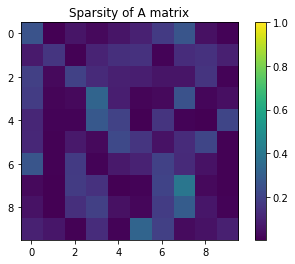

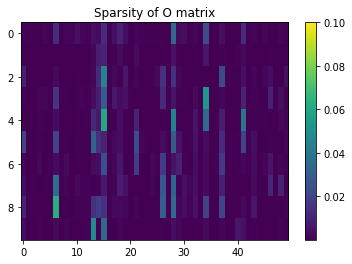

In [ ]:
visualize_sparsities(HMM, O_max_cols=50)

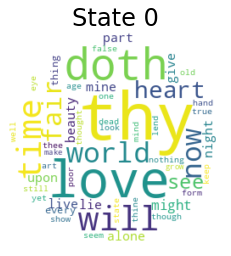

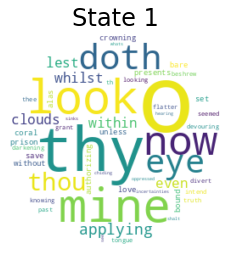

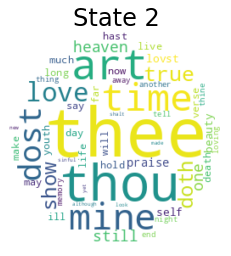

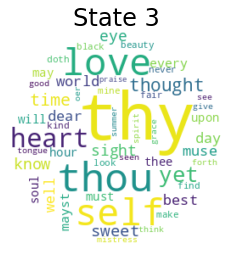

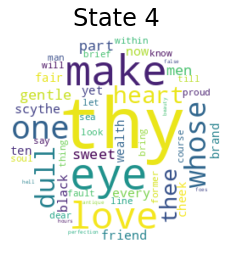

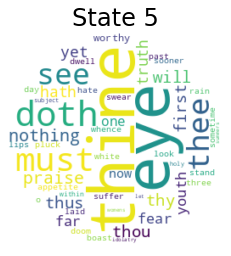

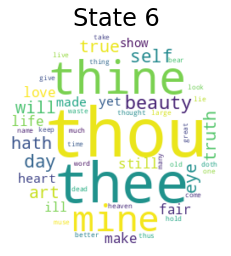

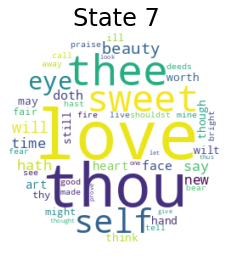

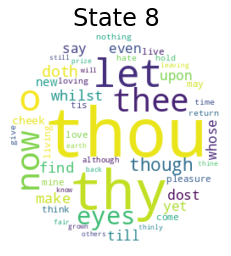

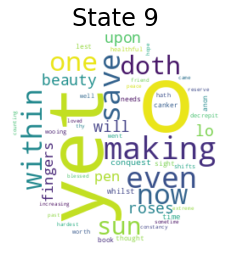

In [ ]:
wordclouds = states_to_wordclouds(HMM, X_map)


Animating...


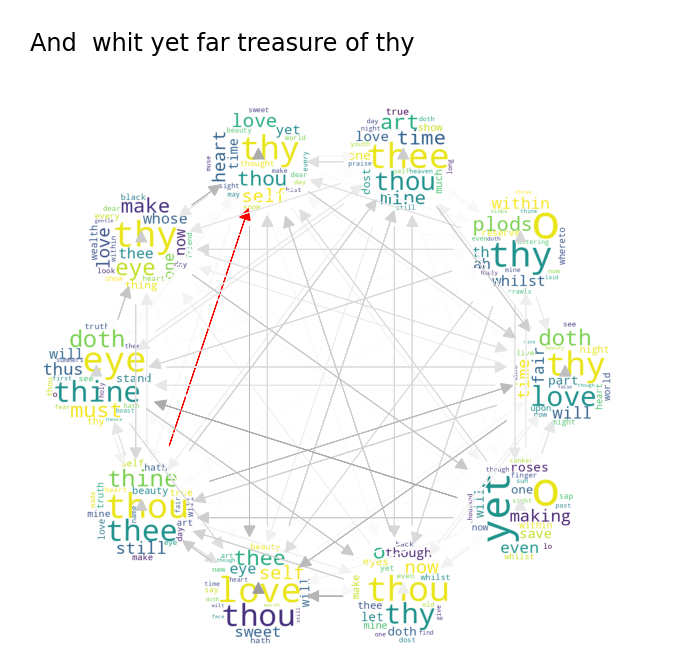

In [ ]:
#cant get to run locally on my mac
from IPython.display import HTML
anim = animate_emission(HMM, X_map, M=8, seed=1)
HTML(anim.to_html5_video())